In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [324]:
def time_conversion(dataset,column,conversion_factor=0.001):
    '''Converts the timestamps in the dataset from ms to seconds (0.001)'''
    dataset[column] = dataset[column]*conversion_factor
    #dataset.loc[dataset[column].apply(lambda x: x*conversion_factor)]
    return dataset

def start_interval_from_zero(dataset):
    '''Subtracts the first timestamp value from all timestamps, so spike times begin from zero onward'''
    new_zero = dataset['timestamp'].min()
    return dataset['timestamp'].apply(lambda x: x - new_zero)

def number_of_trials(behaviour_dataset):
    '''Returns the number of trials for a given session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: the number of trials
    '''
    return len(trials)

def trials_begin_end(behaviour_dataset):
    '''Returns the number of trials for a given session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session
    OUTPUT: a list of tuples (trial_start,trial_end)
    '''
    n_trials = number_of_trials(behaviour_dataset)
    boundaries = []
    for trial in range(n_trials):
        lower_boundary = behaviour_dataset.iloc[trial].trial_start
        upper_boundary = behaviour_dataset.iloc[trial].trial_end
        boundaries.append((lower_boundary,upper_boundary))
    return boundaries

def spikes_in_interval(dataset,interval_start,interval_end):
    '''Returns all spikes in the dataset whose timestamps lay between the interval start and end boundaries
    
    INPUT: a Pandas DataFrame containing the spike data from the SpikeData.dat file of the corresponding session
    and the time boundaries that define the interval
    OUTPUT: a Pandas DataFrame containing the subset of spikes_dataset whose timestamps lie within the boundaries
    '''
    return dataset.loc[(dataset['timestamp'] >= interval_start) &
                       (dataset['timestamp'] <= interval_end)]

def separate_into_trials(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each trial in the session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each trial
    '''
    trials = []
    time_boundaries = trials_begin_end(behaviour_dataset)
    
    for trial in range(number_of_trials(behaviour_dataset)):
        trial_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][0],time_boundaries[trial][1])
        trials.append(trial_spikes)
    return trials

def build_ITIs(behaviour_dataset,spikes_dataset):
    '''Splits the spikes_dataset into a list whose elements correspond to the spikes in each ITI in the session
    
    INPUT: a Pandas DataFrame containing the data from the Behavior.dat file of the corresponding session and a
    Pandas DataFrame containing the spike data from the accompanying SpikeData.dat
    OUTPUT: a list in which each element is a  Pandas DataFrame containing the subset of spikes_dataset
    whose timestamps lie within the boundaries of each ITI
    '''
    ITIs = []
    time_boundaries = trials_begin_end(behaviour_dataset)
    
    for trial in range(number_of_trials(behaviour_dataset)-1):
        ITI_spikes = spikes_in_interval(spikes_dataset,time_boundaries[trial][1],time_boundaries[trial+1][0])
        ITIs.append(ITI_spikes)
    return ITIs

def isi_estimate(spike_times):
    isi = []
    for timestamp in range(len(spike_times)-1):
        current_isi = spike_times[timestamp+1] - spike_times[timestamp]
        isi.append(current_isi)
    return isi

def kernel_conv(kernel,current_time,spike_time,resolution):
    if kernel == 'rectangular':
        temporal_displacement = abs(current_time - spike_time)
        if temporal_displacement < resolution:
            return 1/resolution
        else:
            return 0
    
    elif kernel == 'gaussian':
        temporal_displacement = abs(current_time - spike_time)
        return np.exp(-temporal_displacement**2/(2*resolution**2))/resolution*np.sqrt(2)
    
    elif kernel == 'alpha':
        temporal_displacement = current_time - spike_time
        if temporal_displacement > 0:
            return (temporal_displacement/resolution**2)*np.exp(-temporal_displacement/resolution)
        else:
            return 0
    else:
        raise Exception("Invalid kernel.")

def windowed_signal(spike_times,starting_point=0,sampling_rate=0.01,kernel='rectangular',resolution=0.1):
    '''
    INPUT:
    starting_point: first timepoint [float]
    sampling_rate: 1/# of points in which we shall estimate our firing rate [float]
    kernel: the kernel each spike shall be convolved with (options: rectangular, gaussian and alpha) [string]
    resolution: the parameter controlling the width of the window (i.e. sigma in the gaussian kernel,
        window width in the rectangular kernel) [float]
    spike_times: an array containing the timestamp for each spike [list(float)]
    
    OUTPUT:
    rates: an array containing the estimated spiking rate at each timepoint [list(float)]
    '''
    current_time = starting_point
    #sampling_rate = 0.01
    rates = []
    
    while current_time <= max(spike_times):
        current_time += sampling_rate
        contribution_to_rate = []
        '''We calculate the contribution each spike in the train (instant) makes to the firing rate estimated at
        time (current_time) by convolving the spike with a given kernel, considering the temporal displacement
        between them.

        Larger temporal displacements should yield less contribution to the rate estimate, whereas spikes closer
        to the timepoint we are interested in should yield a larger contribution.'''
        for spike_timestamp in spike_times:
            contribution_to_rate.append(kernel_conv(kernel,current_time,spike_timestamp,resolution=resolution))

        #Sum the contributions of all spikes to achieve the rate estimate at time current_time
        current_rate = np.sum(contribution_to_rate)
        #Which we append to our rates list, which will yield our firing rate (hz) x time (s) plot afterwards
        rates.append(current_rate)
    return rates

In [240]:
#Fetch (in order) the session/trial pair in which learning occurred
learning_trial_number = [23,23,14,5,10,12,5,18,11,8]
analyse_trial_session = ['201222','201227','201229','181012','181020',
                            '150628','150630','150707','190214','190228']

#Zip these two lists so the elements will be paired into tuples (session,trial)
learning_events = zip(analyse_trial_session,learning_trial_number)

#Convert time from ms to s
time_conversion = 0.001

#1 second bins for population rate histogram? Seems reasonable
binsize = 10;

#load data for each event
#for event in learning_events:

#load data, plot rate histogram and rate distributions
data = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_SpikeData.dat',
                     header=None,names=['timestamp','cell'],engine = 'python')
trials = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_Behavior.dat',
                     header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python')

In [241]:
data['timestamp'] = data['timestamp'].apply(lambda x: x * time_conversion)

In [242]:
data

,timestamp,cell
0,6.0322,1.0
1,7.6991,1.0
2,8.2325,1.0
3,8.6552,1.0
4,21.5043,1.0
...,...,...
1107202,7119.1266,27.0
1107203,7119.1470,27.0
1107204,7119.1672,27.0
1107205,7119.4356,27.0


In [216]:
neuron_1 = data.loc[data['cell']==1]

In [217]:
neuron_1

,timestamp,cell
0,6.0322,1.0
1,7.6991,1.0
2,8.2325,1.0
3,8.6552,1.0
4,21.5043,1.0
...,...,...
17965,7117.6131,1.0
17966,7118.0181,1.0
17967,7118.2969,1.0
17968,7118.3492,1.0


In [7]:
def isi_estimate(spike_times):
    isi = []
    for timestamp in range(len(spike_times)-1):
        current_isi = spike_times[timestamp+1] - spike_times[timestamp]
        isi.append(current_isi)
    return isi

In [219]:
example_isi = isi_estimate(neuron_1['timestamp'])

In [220]:
mean = np.mean(example_isi)
std = np.std(example_isi)
print(mean,std)
print(mean/std)

0.395815298569759 1.5542106336778823
0.25467288023445195


In [221]:
example_isi[:10]

[1.666900000000001,
 0.5333999999999994,
 0.42270000000000074,
 12.8491,
 0.7635000000000005,
 0.013700000000000045,
 0.05729999999999791,
 2.672900000000002,
 5.569800000000001,
 6.353800000000003]

In [222]:
bins = np.arange(0,3,0.05)

In [223]:
import statistics


(array([6006., 3785., 1849., 1027.,  665.,  459.,  346.,  283.,  246.,
         195.,  187.,  172.,  151.,  116.,  123.,  122.,  102.,   84.,
          95.,   73.,   70.,   73.,   79.,   66.,   72.,   67.,   64.,
          51.,   53.,   44.,   49.,   56.,   47.,   56.,   31.,   23.,
          32.,   29.,   28.,   27.,   28.,   36.,   31.,   31.,   31.,
          26.,   25.,   18.,   28.,   19.,   15.,   10.,   24.,   19.,
          18.,   16.,   17.,   15.,   11.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95]),
 <BarContainer object of 59 artists>)

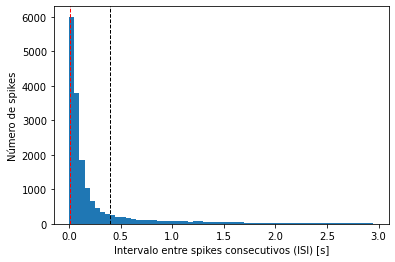

In [224]:
plt.axvline(statistics.mode(example_isi), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(example_isi), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Intervalo entre spikes consecutivos (ISI) [s]')
plt.ylabel('Número de spikes')
plt.hist(example_isi,bins)

In [225]:
trials

,trial_start,trial_end,rule,reward,turn_side,light_side
0,2046699.6,2053336.2,2.0,1.0,0.0,0.0
1,2120769.4,2128239.8,2.0,0.0,0.0,1.0
2,2163824.0,2168159.4,2.0,1.0,1.0,1.0
3,2336475.7,2339710.7,2.0,0.0,0.0,1.0
4,2377129.1,2383465.6,2.0,0.0,1.0,0.0
5,2470842.0,2474076.9,2.0,1.0,0.0,0.0
6,2537441.5,2542610.7,2.0,0.0,0.0,1.0
7,2592135.1,2596737.4,2.0,1.0,1.0,1.0
8,2685881.3,2690183.4,2.0,1.0,0.0,0.0
9,2787664.8,2791199.9,2.0,1.0,0.0,0.0


In [245]:
trials.iloc[0]

trial_start    2046699.6
trial_end      2053336.2
rule                 2.0
reward               1.0
turn_side            0.0
light_side           0.0
Name: 0, dtype: float64

In [227]:
data['timestamp']

0             6.0322
1             7.6991
2             8.2325
3             8.6552
4            21.5043
             ...    
1107202    7119.1266
1107203    7119.1470
1107204    7119.1672
1107205    7119.4356
1107206    7119.4920
Name: timestamp, Length: 1107207, dtype: float64

In [246]:
first_trial = data.loc[(data['timestamp'] >= trials.iloc[0].trial_start*0.001) &
                       (data['timestamp'] <= trials.iloc[0].trial_end*0.001)]
first_trial

,timestamp,cell
1705,2047.5017,1.0
1706,2052.4002,1.0
24559,2046.7083,2.0
24560,2047.1147,2.0
24561,2047.1921,2.0
...,...,...
1056259,2050.7781,27.0
1056260,2051.0686,27.0
1056261,2051.4120,27.0
1056262,2051.6796,27.0


(array([125., 109., 163., 144., 127., 133., 139., 141., 128., 107.]),
 array([2046.7054 , 2047.36804, 2048.03068, 2048.69332, 2049.35596,
        2050.0186 , 2050.68124, 2051.34388, 2052.00652, 2052.66916,
        2053.3318 ]),
 <BarContainer object of 10 artists>)

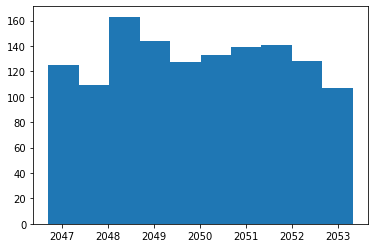

In [247]:
plt.hist(first_trial['timestamp'])

In [248]:
first_trial['timestamp']

1705       2047.5017
1706       2052.4002
24559      2046.7083
24560      2047.1147
24561      2047.1921
             ...    
1056259    2050.7781
1056260    2051.0686
1056261    2051.4120
1056262    2051.6796
1056263    2051.7772
Name: timestamp, Length: 1316, dtype: float64

In [249]:
#first_trial['timestamp'] = first_trial['timestamp'].apply(lambda x: x * time_conversion)
new_zero = first_trial['timestamp'].min()
first_trial['timestamp'] = first_trial['timestamp'].apply(lambda x: x - new_zero)
first_trial['timestamp']

/tmp/ipykernel_6022/1351454659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_trial['timestamp'] = first_trial['timestamp'].apply(lambda x: x - new_zero)


1705       0.7963
1706       5.6948
24559      0.0029
24560      0.4093
24561      0.4867
            ...  
1056259    4.0727
1056260    4.3632
1056261    4.7066
1056262    4.9742
1056263    5.0718
Name: timestamp, Length: 1316, dtype: float64

In [250]:
lesser_boundary = first_trial['timestamp'].min()
upper_boundary = first_trial['timestamp'].max()

(array([ 71.,  76.,  63.,  83., 107.,  86.,  81.,  82.,  76.,  81.,  86.,
         89.,  82.,  79.,  72.,  63.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
        5.2, 5.6, 6. , 6.4]),
 <BarContainer object of 16 artists>)

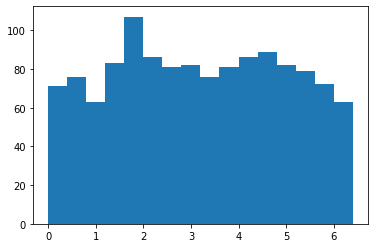

In [251]:
bins = np.arange(lesser_boundary,upper_boundary,0.4)
plt.hist(first_trial['timestamp'],bins)

In [252]:
rates_gauss = windowed_signal(first_trial['timestamp'],starting_point=lesser_boundary,
                              sampling_rate=0.01,kernel='gaussian',resolution=0.3)

Text(0.5, 0, 'Time (s)')

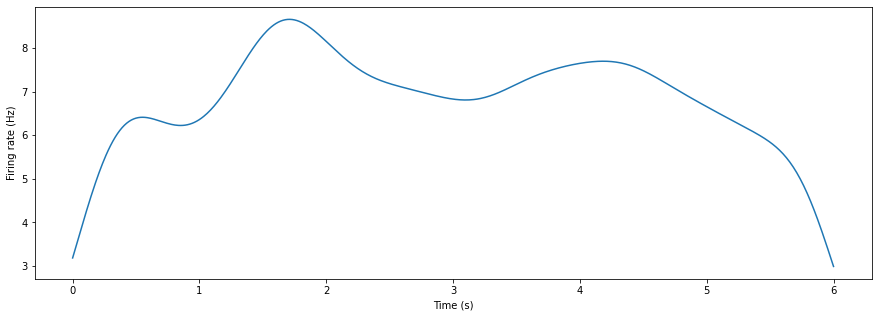

In [253]:
normalised_rates = np.array(rates_gauss)*0.01
normalised_rates

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,6, 663),normalised_rates)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')

In [254]:
#check for differing means in correct and incorrect trials (t-test, two-tailed [no preference])
np.mean(normalised_rates)

6.822044850459211

In [262]:
second_trial = data.loc[(data['timestamp'] >= trials.iloc[1].trial_start* time_conversion) &
                       (data['timestamp'] < trials.iloc[1].trial_end* time_conversion)]

In [263]:
second_trial['timestamp'] = second_trial['timestamp'].apply(lambda x: x * 1)
new_zero = second_trial['timestamp'].min()
second_trial['timestamp'] = second_trial['timestamp'].apply(lambda x: x - new_zero)
second_trial['timestamp']

/tmp/ipykernel_6022/1093380665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_trial['timestamp'] = second_trial['timestamp'].apply(lambda x: x * 1)
/tmp/ipykernel_6022/1093380665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_trial['timestamp'] = second_trial['timestamp'].apply(lambda x: x - new_zero)


1871       3.5058
1872       6.1972
1873       7.3570
24825      0.7414
24826      1.1998
            ...  
1056904    6.7419
1056905    6.7639
1056906    6.7848
1056907    6.9790
1056908    7.2347
Name: timestamp, Length: 1576, dtype: float64

In [198]:
rates_gauss = windowed_signal(second_trial['timestamp'],starting_point=lesser_boundary,
                              sampling_rate=0.01,kernel='gaussian',resolution=0.3)

In [203]:
print(len(rates_gauss),second_trial['timestamp'].max() - second_trial['timestamp'].min())

747 7.461499999999887


Text(0.5, 0, 'Time (s)')

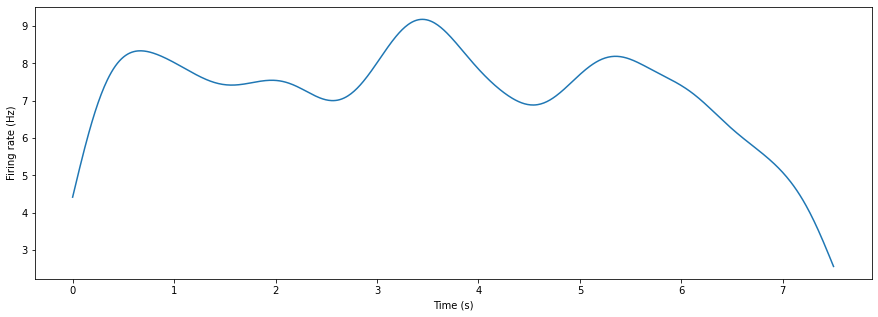

In [204]:
normalised_rates = np.array(rates_gauss)*0.01
normalised_rates

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,7.5, 747),normalised_rates)
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')

In [205]:
#check for differing means in correct and incorrect trials (t-test, two-tailed [no preference])
np.mean(normalised_rates)

7.256643474702543

In [ ]:
learning_trial_number = [23,23,14,5,10,12,5,18,11,8]
analyse_trial_session = ['201222','201227','201229','181012','181020',
                            '150628','150630','150707','190214','190228']

#Zip these two lists so the elements will be paired into tuples (session,trial)
learning_events = zip(analyse_trial_session,learning_trial_number)

#Convert time from ms to s
time_conversion = 0.001

#1 second bins for population rate histogram? Seems reasonable
binsize = 10;

#load data for each event
#for event in learning_events:

#load data, plot rate histogram and rate distributions
data = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_SpikeData.dat',
                     header=None,names=['timestamp','cell'],engine = 'python')
trials = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_Behavior.dat',
                     header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python')

#%=======================================================================

In [ ]:
#for session in list_of_sessions:

#load data
behaviour_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_Behavior.dat',
                     header=None,names=['trial_start','trial_end','rule','reward','turn_side',
                                       'light_side'],engine = 'python') #Behaviour.dat dataset
spikes_dataset = pd.read_table(filepath_or_buffer = 'mPFC_Data/201222/201222_SpikeData.dat',
                     header=None,names=['timestamp','cell'],engine = 'python') #SpikeData.dat dataset

In [ ]:
#adjust times
spikes_dataset = time_conversion(spikes_dataset,'timestamp') #timestamps now in seconds
behaviour_dataset = time_conversion(behaviour_dataset,'trial_start') #trial_start now in seconds
behaviour_dataset = time_conversion(behaviour_dataset,'trial_end') #trial_end now in seconds

In [ ]:
#number of trials and their time boundaries
n_trials = number_of_trials(behaviour_dataset)
trial_intervals = trials_begin_end(behaviour_dataset)

In [316]:
#split the spikes_dataset into separate trials and ITIs
trials = separate_into_trials(behaviour_dataset,spikes_dataset)
ITIs = build_ITIs(behaviour_dataset,spikes_dataset)